# 代表的な次元削除を行なう 10本 Knock

## Knock21: PCA を実施してみよう
### 主成分分析（PCA: Principal Component Analysis）
多次元 Data のもつ情報をできるだけ損なわずに低次元にする方法。
- 次元削除で最も簡単な手法でありながら、広い分野で使われている。
- Data を**相関関係にある複数の説明変数**を相関関係の少ない説明変数にまとめる。それにより、相関による Bias が軽減され、Model がより適切な学習が行なえるようになる。
 ※具体的には**分散共分散行列の固有 Vector を取る** 。Data がよくばらついている方向に合わせて空間の軸を取り直す、ということになる。
 >分散共分散行列
 > 変数同士のばらつきをまとめた表

In [1]:
# Iris data の読み込み
from IPython.display import display
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.loc[df['target'] == 0, 'target_name'] = 'setosa'
df.loc[df['target'] == 1, 'target_name'] = 'versicolor'
df.loc[df['target'] == 2, 'target_name'] = 'virginica'
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


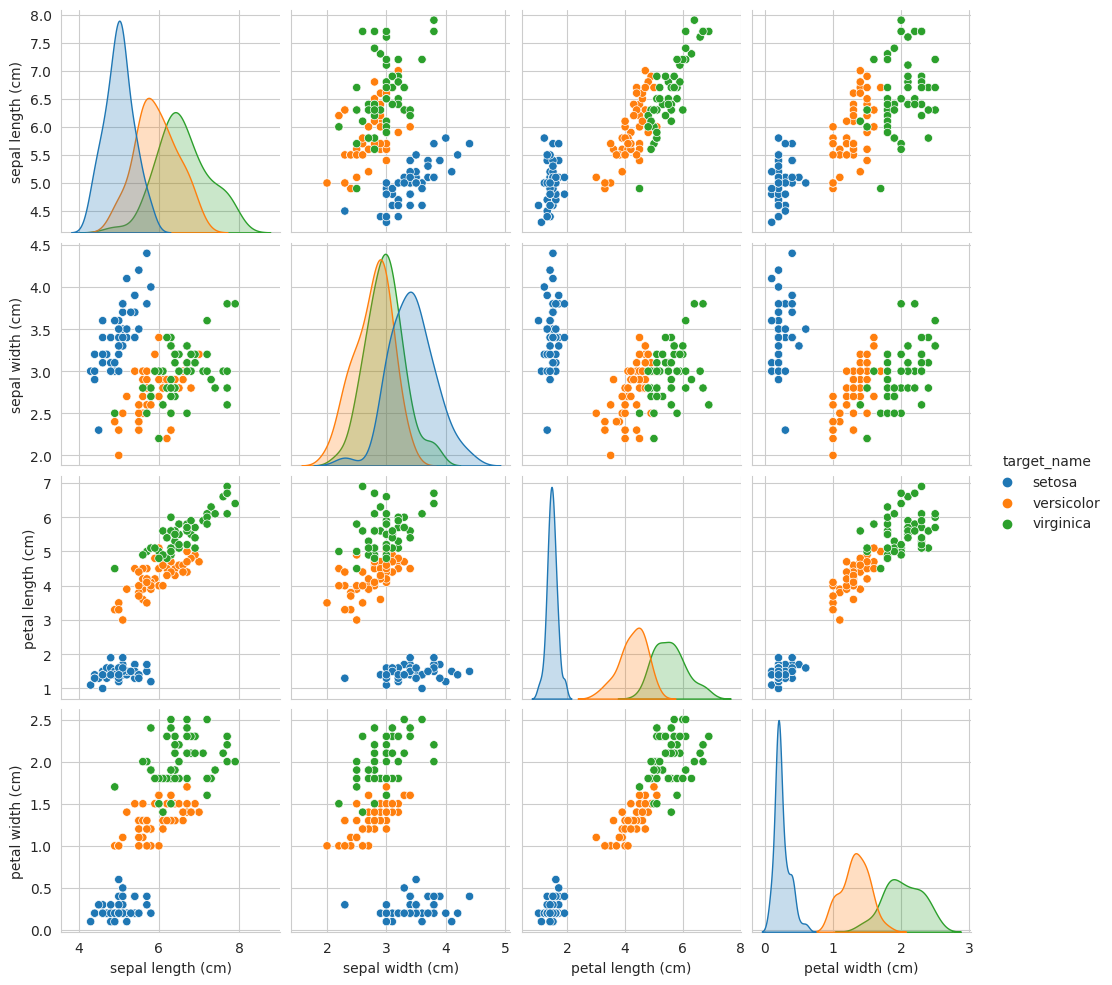

In [2]:
# Iris の散布図行列
import seaborn as sns
sns.pairplot(df, vars=df.columns[:4], hue='target_name')

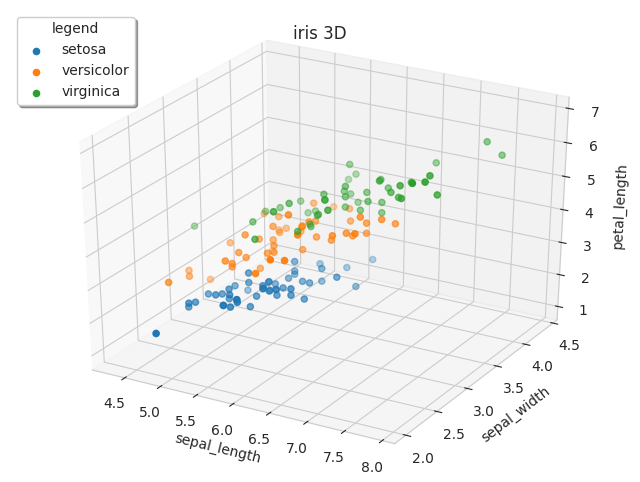

In [3]:
# Iris の３次元立体図
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
for c in df['target_name'].unique():
    ax.scatter(df.iloc[:, 0][df['target_name'] == c], df.iloc[:, 1][df['target_name'] == c],
               df.iloc[:, 2][df['target_name'] == c], label=c)
ax.set_title('iris 3D')
ax.set_xlabel('sepal_length')
ax.set_ylabel('sepal_width')
ax.set_zlabel('petal_length')
ax.legend(loc=2, title='legend', shadow=True)
plt.show()

In [4]:
# PCA 結果
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(random_state=0)
X_pc = pca.fit_transform(df.iloc[:, 0:4])
df_pca = pd.DataFrame(X_pc, columns=['PC{}'.format(i + 1) for i in range(len(X_pc[0]))])
print("主成分の数: ", pca.n_components_)
print("保たれている情報: ", np.sum(pca.explained_variance_ratio_))
display(df_pca.head())

主成分の数:  4
保たれている情報:  1.0


,PC1,PC2,PC3,PC4
0,-2.684126,0.319397,-0.027915,-0.002262
1,-2.714142,-0.177001,-0.210464,-0.099027
2,-2.888991,-0.144949,0.017900,-0.019968
3,-2.745343,-0.318299,0.031559,0.075576
4,-2.728717,0.326755,0.090079,0.061259


#### 主成分（PC: Principal Component
Data を要約（圧縮）したあとの新しい合成変数で、第１主成分（PC1）に最も多くの情報が詰まっていて第２主成分（PC2)以降段々に小さくなる。

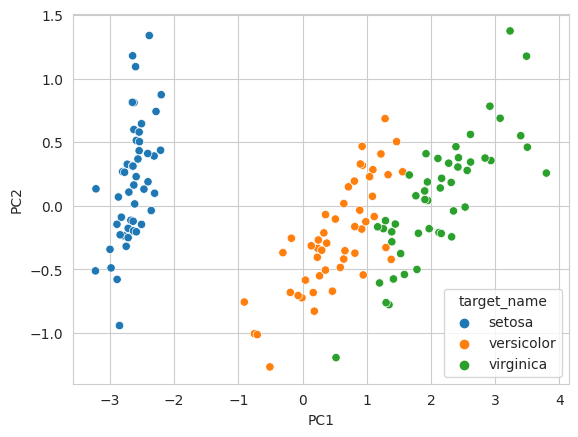

In [5]:
# PC1 と PC2 を可視化
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue=df['target_name'])

PCA は、多次元 Data の特徴を可視化する手段として、とても有用である。

### Knock22: 主成分を解釈してみよう

#### 固有 Vector: `components_`
PCA で Data のバラつきが大きい方向に軸を取り直した Vector.
各主成分と元 Data の相関関係（-1 ~ 1）を意味している。
元 Data と主成分の影響度合いを表す。

#### 主成分得点: `explained_variance`
固有 Vector と元 Data を掛け合わせた値。
主成分得点 = 元 Data × 固有 Vector

#### 固有値: `explained_variance_`
固有 Vector の方向に沿った Data の分散の大きさ。
固有値が大きい固有 Vector ほど、Data の分散をよく説明しており、Data の重要な特徴を捉えている。
Data を標準化している場合、各 PC は１以上あれば元 Data より情報を持っていることになり、４次元 Data なら全ての合計は４になる。

#### 寄与率: `explained_varicance_ratio_`
固有値から算出した、Data 特徴の捉え度合い。
寄与率 = 固有値 ÷ 固有値の合計

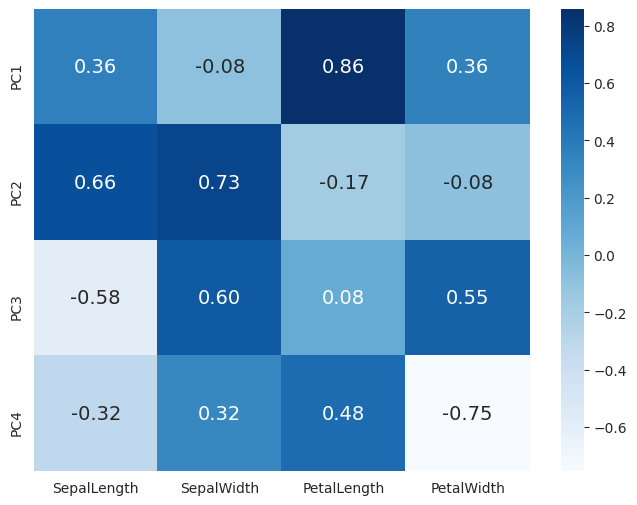

In [6]:
# 各主成分と元 Data の相関図
import seaborn as sns

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
sns.heatmap(pca.components_,
            cmap='Blues',
            annot=True,
            annot_kws={'size': 14},
            fmt='.2f',
            xticklabels=['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth'],
            yticklabels=['PC1', 'PC2', 'PC3', 'PC4'],
            ax=ax)
plt.show()

主成分がどんな内容の軸になったかは、PCA の結果を見て判断する必要がある。

### Knock23: Scree-plot で次元削減数を探索してみよう
PCA を教師あり学習の説明変数として利用する場合、次元は減らしつつも、元の情報はなるべく保持している PC まで使う必要がある。
そのため、有効な PC数を探索する必要がある。

In [7]:
# Wine-data の取得
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
display(df_wine.shape)
display(df_wine.head())

(178, 14)

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


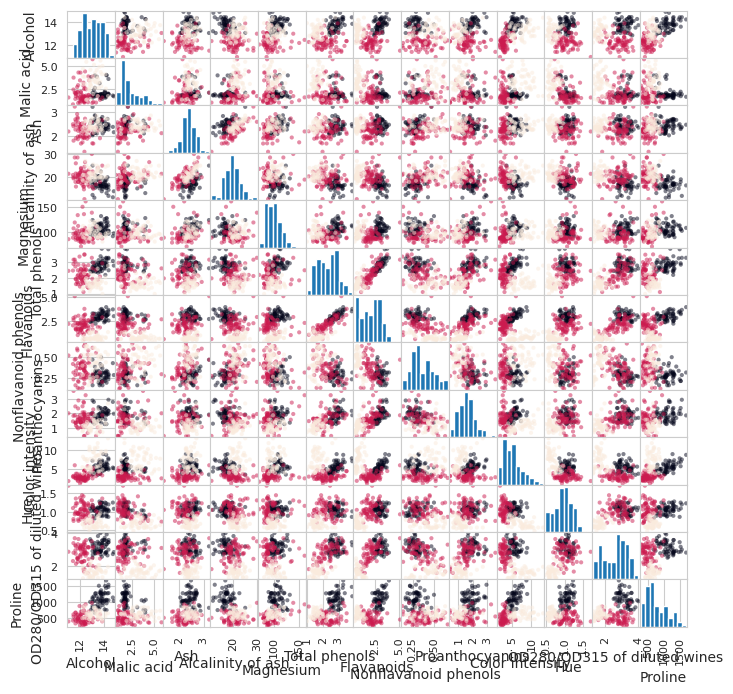

In [8]:
# Wine-data の分布行列
from pandas import plotting
plotting.scatter_matrix(df_wine.iloc[:, 1:], figsize=(8, 8), c=list(df_wine.iloc[:, 0]), alpha=0.5)
plt.show()

In [9]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np

sc = preprocessing.StandardScaler()
X = df_wine.iloc[:, 1:]
X_norm = sc.fit_transform(X)

pca = PCA(random_state=0)
X_pc = pca.fit_transform(X_norm)
df_pca = pd.DataFrame(X_pc, columns=['PC{}'.format(i + 1) for i in range(len(X_pc[0]))])
print(f"主成分: {pca.n_components_}")
print(f"保たれている情報: {round(np.sum(pca.explained_variance_ratio_), 2)}")
display(df_pca.head())

主成分: 13
保たれている情報: 1.0


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,-0.223880,0.596427,0.065139,0.641443,1.020956,-0.451563,0.540810,-0.066239
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,-0.927120,0.053776,1.024416,-0.308847,0.159701,-0.142657,0.388238,0.003637
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,0.549276,0.424205,-0.344216,-1.177834,0.113361,-0.286673,0.000584,0.021717
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,0.114431,-0.383337,0.643593,0.052544,0.239413,0.759584,-0.242020,-0.369484
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,-0.406520,0.444074,0.416700,0.326819,-0.078366,-0.525945,-0.216664,-0.079364


- Parameter の `n_components` を指定しないとき、主成分は元 Data の次元数と一致する。
- 全次元を対象にすると保たれている情報は 1.0(100%) になる。

固有値と寄与率を確認しどこまで利用できそうか探索する。

In [10]:
# 固有値の確認
pd.DataFrame(np.round(pca.explained_variance_, 2), index=['PC{}'.format(x + 1) for x in range(len(df_pca.columns))], columns=['固有値'])

,固有値
PC1,4.73
PC2,2.51
PC3,1.45
PC4,0.92
PC5,0.86
PC6,0.65
PC7,0.55
PC8,0.35
PC9,0.29
PC10,0.25


- 固有値（explained_variance_）は、主成分の分散のことで、主成分の情報量の大きさを表す。
- PC1 がもっとも大きく、以降段々と小さくなっていく。

標準化している場合、**固有値が 1.0 以上のものを使う** ということが一番 Simple な判断基準になる。

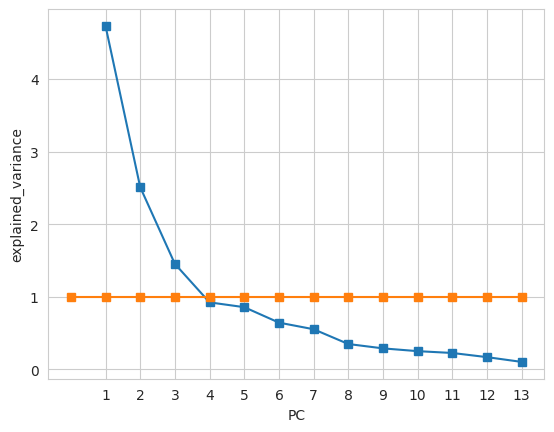

In [11]:
# 固有値の Scree-plot
line = np.ones(14)
plt.plot(np.append(np.nan, pca.explained_variance_), 's-')
plt.plot(line, 's-')
plt.xlabel('PC')
plt.ylabel('explained_variance')
plt.xticks(np.arange(1, 14, 1))
plt.grid
plt.show()

#### Scree-plot
- 固有値を最大値から最小値まで降順で plot した Graph のこと。
- 崖 (Scree) のような形になる。

固有値が、ある段階から急に小さな値となって以降は安定する箇所までを利用することが望ましいとされている。
※あくまで目安のため、実際は ±2 ぐらいを試すのが良い。

標準化していると時の固有値 1.0 の基準線とあわせて確認するのが良い。

### Knock24: 寄与率で次元削減数を探索してみよう

In [12]:
# 寄与率
pd.DataFrame(np.round(pca.explained_variance_ratio_, 2),
             index=['PC{}'.format(x + 1) for x in range(len(df_pca.columns))], columns=['寄与率'])

,寄与率
PC1,0.36
PC2,0.19
PC3,0.11
PC4,0.07
PC5,0.07
PC6,0.05
PC7,0.04
PC8,0.03
PC9,0.02
PC10,0.02


#### 寄与率
- 主成分がどの程度、元 Data の情報を保持しているかを表す。
- PC1 がもっとも大きく、以降段々と小さくなっていく。
- 各固有値 ÷ 固有値の合計 = 寄与率

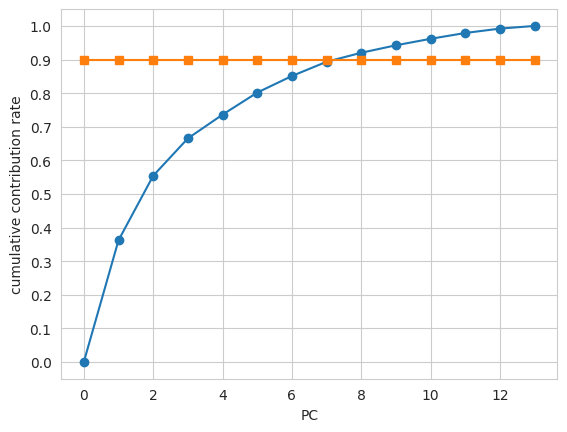

In [13]:
# 累積寄与率
import matplotlib.ticker as ticker

line = np.full(14, 0.9)
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), '-o')
plt.xlabel('PC')
plt.ylabel('cumulative contribution rate')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot(line, 's-')
plt.grid
plt.show()

- 累積寄与率が 90% 以上になるものまで使うことが基準になる。
- Case by Case だが、より次元数を削除したいときは 70% くらいまでにすることもある。

In [14]:
# 累積寄与率を指定して PCA を実行
sc = preprocessing.StandardScaler()
X = df_wine.iloc[:, 1:]
X_norm = sc.fit_transform(X)

pca = PCA(n_components=0.9, random_state=0)
X_pc = pca.fit_transform(X_norm)
df_pca = pd.DataFrame(X_pc, columns=['PC{}'.format(i + 1) for i in range(len(X_pc[0]))])
print(f"主成分の数: {pca.n_components_}")
print(f"保たれている情報: {round(np.sum(pca.explained_variance_ratio_), 2)}")
display(df_pca.head())

主成分の数: 8
保たれている情報: 0.92


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,-0.223880,0.596427,0.065139
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,-0.927120,0.053776,1.024416
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,0.549276,0.424205,-0.344216
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,0.114431,-0.383337,0.643593
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,-0.406520,0.444074,0.416700


#### PCA の補足事項
基本的に Data は標準化させることが推奨。
※ただし、Noise data が多いと正しく軸が取れない場合があるため、標準化する Pattern, しない Pattern の両方を実施し精度が良いほうと取るのが良い。

### Knock25: Isomap で次元削減を実施してみよう
#### Isomap (Isometric mapping)
多様体上の距離を測定し、「多次元尺度構成法」で表現した手法。
> 多次元尺度構成法
> 近いもの同士は近くに配置し、遠いものは遠くに配置する手法。
> ※ Isomap は近いもの同士をより考慮した結果になる。

- PCA は Data が多次元正規分布に従うことを仮定している為、非線形 Data に対してはうまく働かないという問題がある。
- 非線形な変換を行なう手法がいろいろと提案されている。

Text(0, 0.5, 'y')

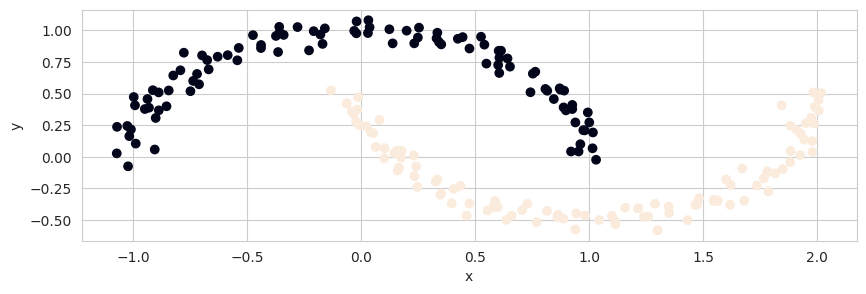

In [15]:
# Moon-data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition, manifold
from sklearn import datasets
from sklearn.decomposition import PCA

X, Y = datasets.make_moons(n_samples=200, noise=0.05, random_state=0)
sc = preprocessing.StandardScaler()
sc.fit(X)
X_norm = sc.transform(X)
plt.figure(figsize=(10, 3))
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('x')
plt.ylabel('y')

In [16]:
# Isomap の実行
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_norm)

isomap_5 = manifold.Isomap(n_neighbors=5, n_components=2)
X_isomap_5 = isomap_5.fit_transform(X_norm)

isomap_10 = manifold.Isomap(n_neighbors=10, n_components=2)
X_isomap_10 = isomap_10.fit_transform(X_norm)

`n_neighbors=`
Isomap は全ての Sample 間の距離を計算するが、細かく計算するのは Sample ごとに最も近い N 個の Sample 間の距離。その N を設定する Parameter.

可視化した結果が良くない場合は、N を変えて試行錯誤することになる。

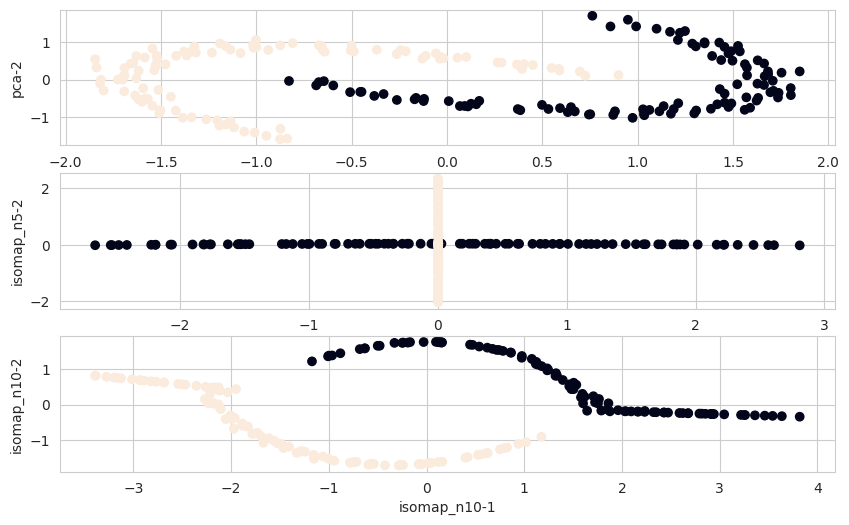

In [17]:
# Isomap の結果
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y)
plt.xlabel('pca-1')
plt.ylabel('pca-2')

plt.subplot(3, 1, 2)
plt.scatter(X_isomap_5[:, 0], X_isomap_5[:, 1], c=Y)
plt.xlabel('isomap_n5-1')
plt.ylabel('isomap_n5-2')

plt.subplot(3, 1, 3)
plt.scatter(X_isomap_10[:, 0], X_isomap_10[:, 1], c=Y)
plt.xlabel('isomap_n10-1')
plt.ylabel('isomap_n10-2')
plt.show()

### Knock26: t-SNE で次元削減を実施してみよう
#### t-SNE (t-distributed Stochastic Neighbor Embedding: ティースニー)
2 or 3 次元への圧縮に特化している Algorithm.
- 必ず失敗する、というわけではないが、次元数４以上の場合は結果が保証されていない。
- 基本的には可視化のための手法。

画像 Data は、Vector 化すると高次元になるため、次元削減 Algorithm が非常に有効になる。

In [18]:
# MNIST の読み込み
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
print(digits.data)

(1797, 64)
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


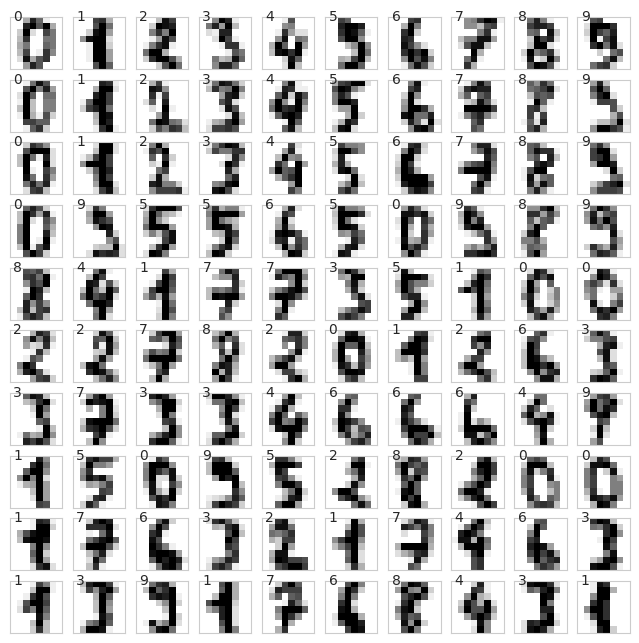

In [19]:
# MNIST を画像表示
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0, 0, str(digits.target[i]))

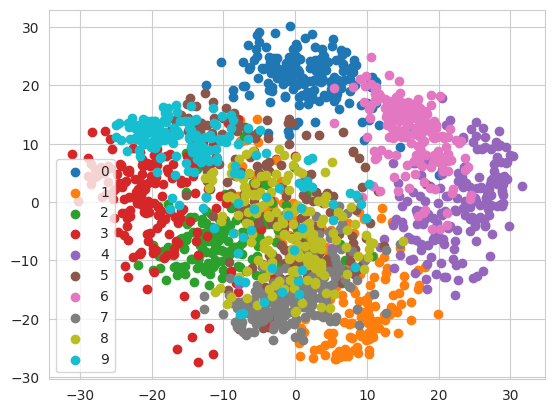

In [20]:
# PCA の結果
from sklearn.decomposition import PCA

X_reduced = PCA(n_components=2).fit_transform(digits.data)
for each_label in digits.target_names:
    c_plot_bool = digits.target == each_label
    plt.scatter(X_reduced[c_plot_bool, 0], X_reduced[c_plot_bool, 1], label=f"{each_label}")
    plt.legend()
plt.show()

PCA は、非線形の Data に対応ができない。

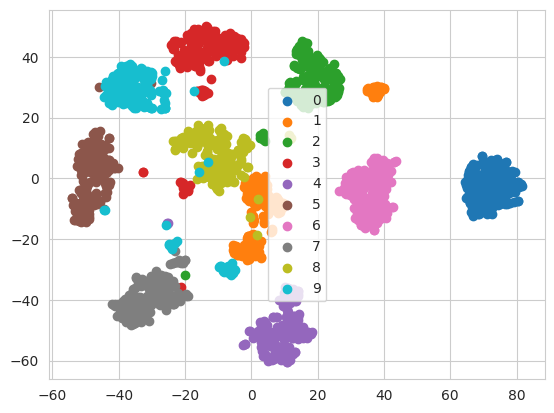

In [21]:
# t-SNE の結果
from sklearn.manifold import TSNE

X_reduced = TSNE(n_components=2, random_state=0).fit_transform(digits.data)
for each_label in digits.target_names:
    c_plot_bool = digits.target == each_label
    plt.scatter(X_reduced[c_plot_bool, 0], X_reduced[c_plot_bool, 1], label=f"{each_label}")
    plt.legend()
plt.show()

t-SNE
- 非線形 Data に対応しうまく分類できる。
- 複雑な Data でもかなり高精度な次元削減ができる。
- 処理に時間がかかる。
- ４次元以上には不向き
- Parameter 調整が必要
- PCA や Isomap より高精度は次元削減が出来る可能性は高いが、一概に優れているといえるわけではない。

PCA
- 多くの場合、入力 Data が複雑になればなるほど  はうまく次元削減できなくなる。

### knock27: t-SNE で最適な Perplexity を探索してみよう
#### Perplexity
t-SNE の重要な Parameter で、どれだけ近傍の点を考慮するかを決めるための Parameter
Data の局所的な特性と全体的な特性のどちらかを考慮するか、その Balance を表す
- 5 ~ 50 の間を選択することが推奨されている
- Default は 30
- 複数並べて確認することが、基本的な Approach になる。

In [22]:
# 最適な Perplexity を探索する関数 (２次元表示)
import time


def create_2d_tsne(target_X, y, y_labels, perplexity_list=[2, 5, 30, 50, 100]):
    fig, axes = plt.subplots(nrows=1, ncols=len(perplexity_list), figsize=(5 * len(perplexity_list), 4))
    for i, (ax, perplexity) in enumerate(zip(axes.flatten(), perplexity_list)):
        start_time = time.time()
        tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(target_X)
        for each_label in y_labels:
            c_plot_bool = y == each_label
            ax.scatter(Y[c_plot_bool, 0], Y[c_plot_bool, 1], label=f"{each_label}")
        end_time = time.time()
        ax.legend()
        ax.set_title(f"perplexity: {perplexity}")
        print(f"perplexity {perplexity} is {end_time - start_time:.2f} seconds.")
    plt.show()


perplexity 2 is 25.92 seconds.
perplexity 5 is 27.43 seconds.
perplexity 30 is 31.66 seconds.
perplexity 50 is 30.96 seconds.
perplexity 100 is 35.28 seconds.


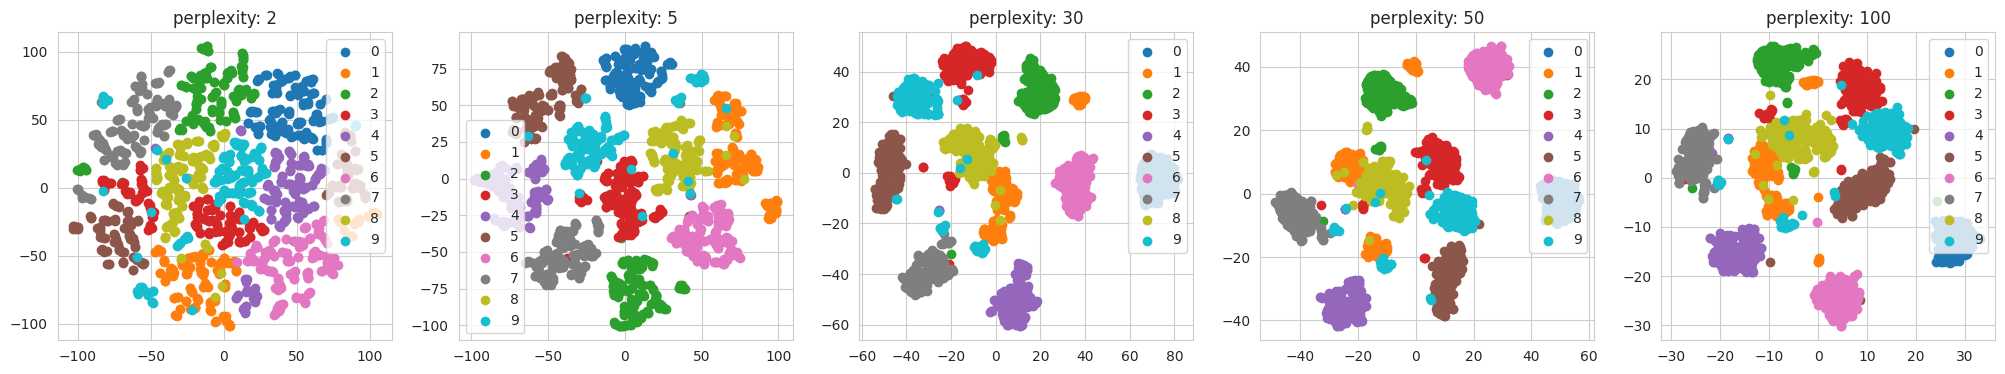

In [23]:
# t-SNE の結果（2次元）
create_2d_tsne(digits.data, digits.target, digits.target_names)

In [24]:
# 最適な Perplexity を探索する関数 (３次元表示)
def create_3d_tsne(target_X, y, y_labels, perplexity_list=[2, 5, 30, 50, 100]):
    fig = plt.figure(figsize=(5 * len(perplexity_list), 4))
    for i, perplexity in enumerate(perplexity_list):
        ax = fig.add_subplot(1, len(perplexity_list), i + 1, projection='3d')
        start_time = time.time()
        tsne = TSNE(n_components=3, random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(target_X)
        for each_label in y_labels:
            c_plot_bool = y == each_label
            ax.scatter(Y[c_plot_bool, 0], Y[c_plot_bool, 1], label=f"{each_label}")
        end_time = time.time()
        ax.legend()
        ax.set_title(f"Perplexity: {perplexity}")
        print(f"perplexity {perplexity} is {end_time - start_time:.2f} seconds.")
    plt.show()

perplexity 2 is 37.64 seconds.
perplexity 5 is 35.51 seconds.
perplexity 30 is 34.46 seconds.
perplexity 50 is 42.23 seconds.
perplexity 100 is 50.20 seconds.


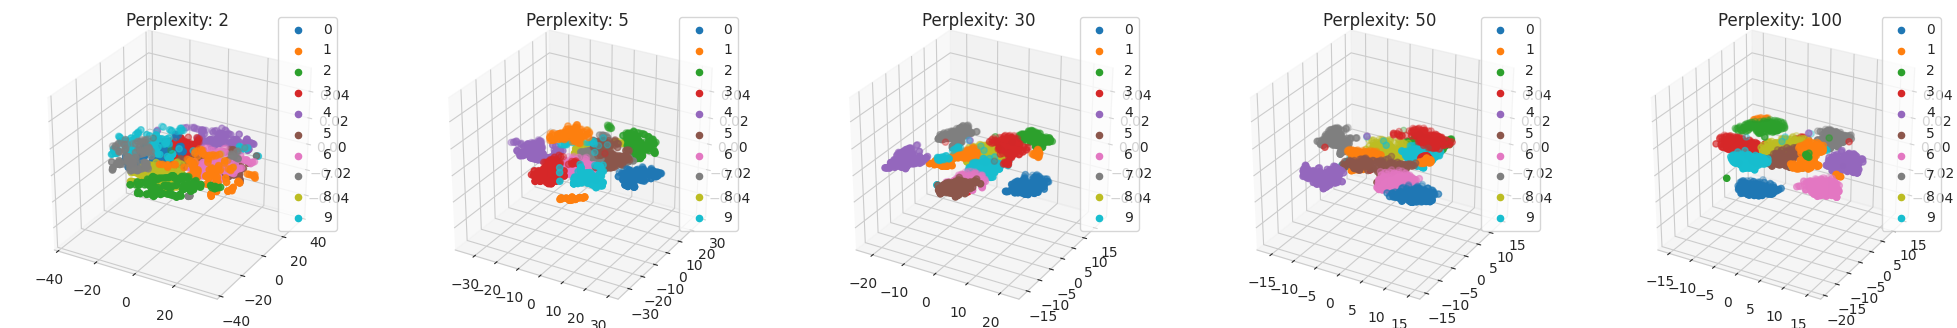

In [25]:
# t-SNE の結果（３次元）
create_3d_tsne(digits.data, digits.target, digits.target_names)

Perplexity の最適な値は、Data-set によって異なるため、複数並べて探索する。

### Knock28: UMAP で次元削減を実施してみよう
#### UMAP (Uniform Manifold Approximation and Projection)
- 2018年に発表された新しい手法
- t-SNE と同程度の精度がある
- 処理速度が速い
- ４次元以上の圧縮に対応
- Parameter の調整は必要
- 非常に高次元で大量の Data に対しても、現実的な時間で実行できる

非線形の高次元 Data を低次元化して可視化する手法として主流になってきている。

In [26]:
# UMAP と t-SNE を実行
import umap

start_time_tsne = time.time()
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(digits.data)
interval_tsne = time.time() - start_time_tsne

start_time_umap = time.time()
embedding = umap.UMAP(n_components=2, random_state=0).fit_transform(digits.data)
interval_umap = time.time() - start_time_umap

print(f"tsne : {np.round(interval_tsne, 2)}s")
print(f"umap : {np.round(interval_umap, 2)}s")

tsne : 30.5s
umap : 15.85s


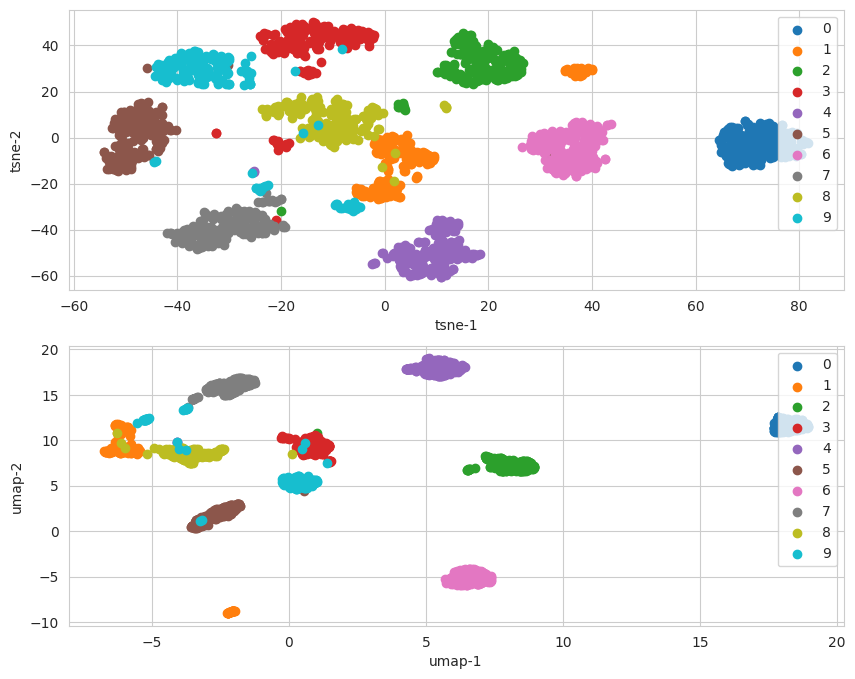

In [28]:
# UMAP と t-SNE の結果
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for each_label in digits.target_names:
    c_plot_bool = digits.target == each_label
    plt.scatter(X_reduced[c_plot_bool, 0], X_reduced[c_plot_bool, 1], label=f"{each_label}")
plt.legend(loc="upper right")
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

plt.subplot(2, 1, 2)
for each_label in digits.target_names:
    c_plot_bool = digits.target == each_label
    plt.scatter(embedding[c_plot_bool, 0], embedding[c_plot_bool, 1], label=f"{each_label}")
plt.legend(loc='upper right')
plt.xlabel('umap-1')
plt.ylabel('umap-2')
plt.show()

- UMAP はどんな Data にも適用でき、複雑な Data の関係性が視覚的に分かりやすくなるため、非常に有効な手法。
- Algorithm については、ひとまず PCA と UMAP の２つを試してみて、より結果が解釈しやすい方を選択するのが良い。
- PCA, UMAP どちらの結果についても納得できなければ、t-SNE など別の Algorithm を試す方針が良い。


### Knock29: UMAP で最適な n_neighbors を探索してみよう
#### n_neighbors=
- UMAP で重要な Parameter
- 大きくすると Macro な、小さくすると Micro な構造を結果に反映させることになる
- 2 ~ 100 の間の値を選択することが推奨
- Default値は、15

In [29]:
# 最適な n_neighbors を探索する関数 (2次元表示)
def create_2d_umap(target_X, y, y_labels, n_neighbors_list=[2, 15, 30, 50, 100]):
    fig, axes = plt.subplots(nrows=1, ncols=len(n_neighbors_list), figsize=(5 * len(n_neighbors_list), 4))
    for i, (ax, n_neighbors) in enumerate(zip(axes.flatten(), n_neighbors_list)):
        start_time = time.time()
        mapper = umap.UMAP(n_components=2, random_state=0, n_neighbors=n_neighbors)
        Y = mapper.fit_transform(target_X)
        for each_label in y_labels:
            c_plot_bool = y == each_label
            ax.scatter(Y[c_plot_bool, 0], Y[c_plot_bool, 1], label=f"{each_label}")
        end_time = time.time()
        ax.legend()
        ax.set_title(f"n_neighbors: {n_neighbors}")
        print(f"n_neighbors {n_neighbors} is {end_time - start_time:.2f}")
    plt.show()


/home/tera/.local/share/virtualenvs/ai_model_building_100-X6USFNE2/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/tera/.local/share/virtualenvs/ai_model_building_100-X6USFNE2/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/tera/.local/share/virtualenvs/ai_model_building_100-X6USFNE2/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

n_neighbors 2 is 28.30
n_neighbors 15 is 6.53
n_neighbors 30 is 7.56
n_neighbors 50 is 7.81
n_neighbors 100 is 8.46


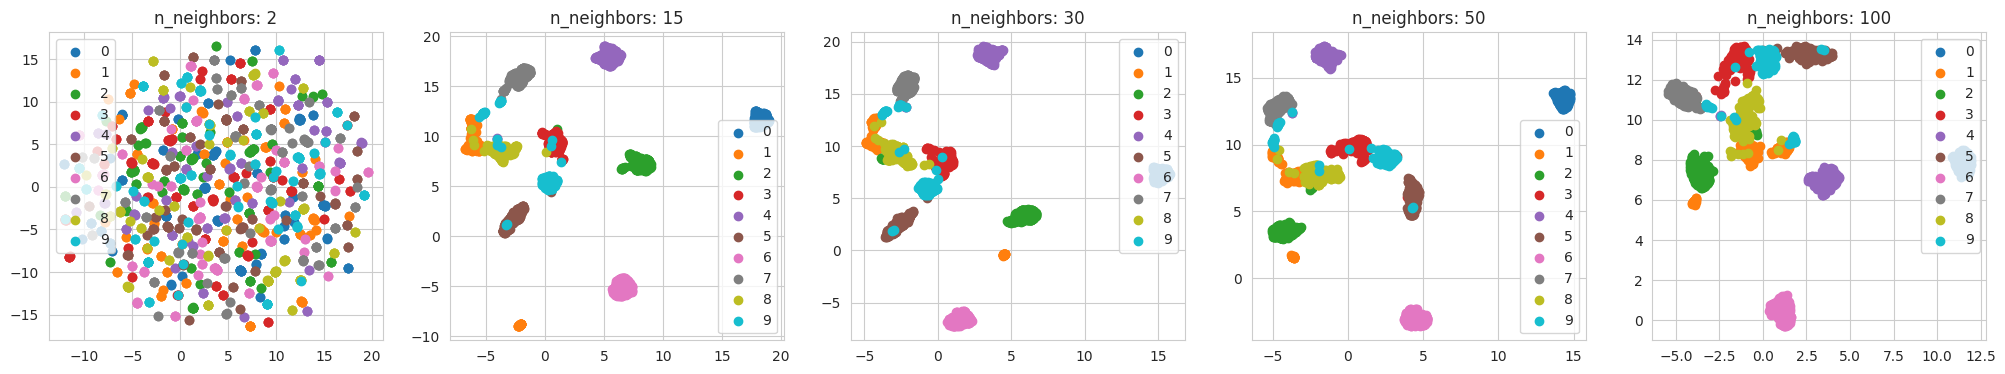

In [31]:
# UMAP の結果 (2次元)
create_2d_umap(digits.data, digits.target, digits.target_names)

In [32]:
# 最適な n_neighbors を探索する関数 (３次元表示)
def create_3d_umap(target_X, y, y_labels, n_neighbors_list=[2, 15, 30, 50, 100]):
    fig = plt.figure(figsize=(5 * len(n_neighbors_list), 4))
    for i, n_neighbors in enumerate(n_neighbors_list):
        ax = fig.add_subplot(1, len(n_neighbors_list), i + 1, projection='3d')
        start_time = time.time()
        mapper = umap.UMAP(n_components=3, random_state=0, n_neighbors=n_neighbors)
        Y = mapper.fit_transform(target_X)
        for each_label in y_labels:
            c_plot_bool = y == each_label
            ax.scatter(Y[c_plot_bool, 0], Y[c_plot_bool, 1], label=f"{each_label}")
        end_time = time.time()
        ax.legend(loc='upper right')
        ax.set_title(f"n_neighbors_list: {n_neighbors}")
        print(f"n_neighbors_list {n_neighbors} is {end_time - start_time:.2f}")
    plt.show()


/home/tera/.local/share/virtualenvs/ai_model_building_100-X6USFNE2/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


n_neighbors_list 2 is 12.07
n_neighbors_list 15 is 3.67
n_neighbors_list 30 is 4.29
n_neighbors_list 50 is 5.24
n_neighbors_list 100 is 5.54


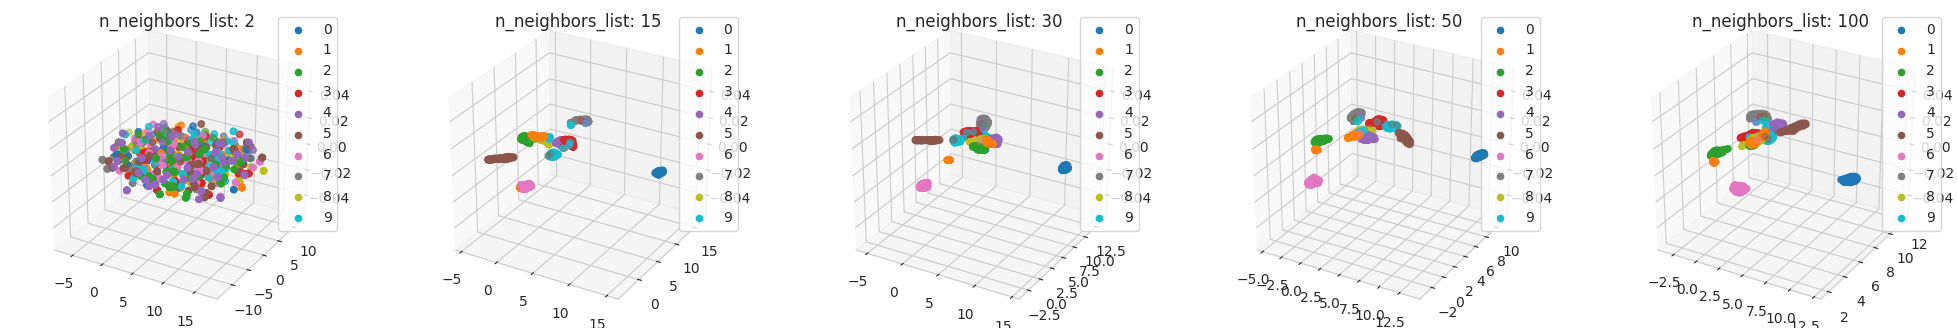

In [33]:
# UMAP の結果１ (3次元)
create_3d_umap(digits.data, digits.target, digits.target_names)

n_neighbors_list 10 is 5.82
n_neighbors_list 15 is 4.44
n_neighbors_list 20 is 4.57
n_neighbors_list 25 is 6.40
n_neighbors_list 30 is 5.77


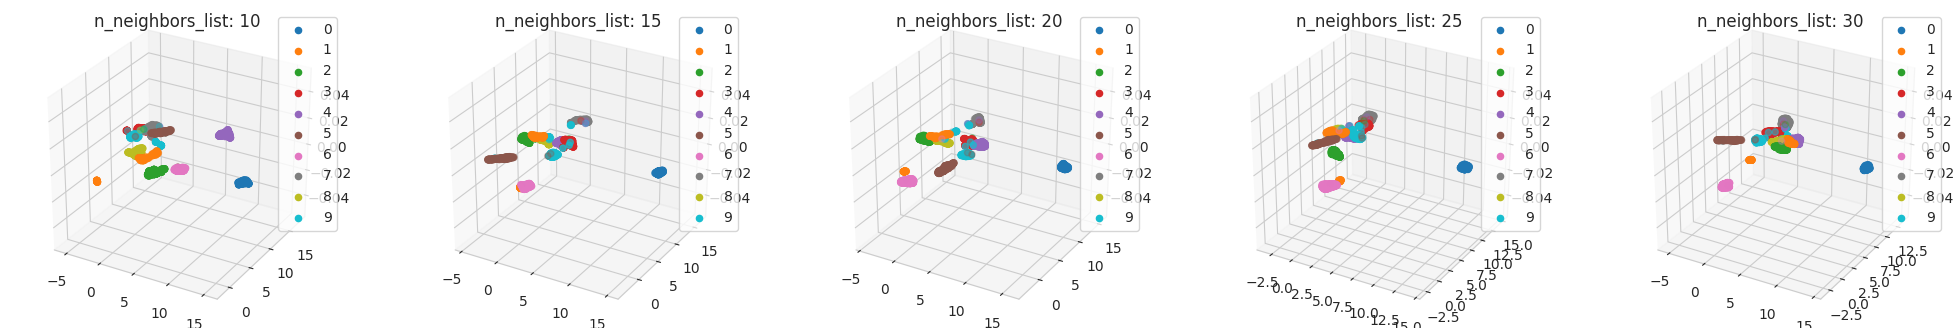

In [34]:
# UMAP の結果（3次元）
create_3d_umap(digits.data, digits.target, digits.target_names, [10, 15, 20, 25, 30])

- どの n_neighbors が最適かは、Data-set によって異なる。
- 関数化して効率よく検証できると良い